# Learning Generative Adversarial Networks (GANs)
This notebook is dedicated to learning and implementing a "basic" GANs network.

In [134]:
import torch
from torch import nn

from datetime import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Example

In [135]:
torch.manual_seed(111)

In [136]:
train_data_length = 1024
train_data = torch.zeros((train_data_length,2))
train_data[:,0] = 2*math.pi*torch.rand(train_data_length)
train_data[:,1] = torch.sin(train_data[:,0])
train_labels = torch.zeros(train_data_length)
trainset = [(train_data[i], train_labels[i]) for i in range(train_data_length)]

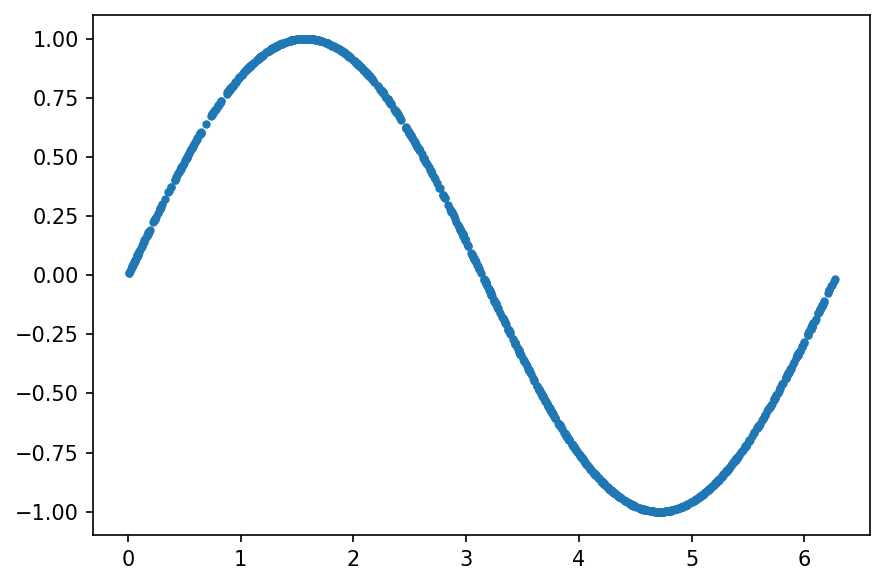

In [137]:
plt.figure(dpi=150)
plt.plot(train_data[:, 0], train_data[:, 1], '.')
plt.tight_layout()

In [138]:
batch_size = 32
train_loader = torch.utils.data.DataLoader(trainset,
                                           batch_size=batch_size,
                                           shuffle=True)

In [139]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        output = self.model(x)
        return output

In [140]:
discriminator = Discriminator()

In [141]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 2),            
        )

    def forward(self, x):
        output = self.model(x)
        return output

In [142]:
generator = Generator()

In [143]:
lr = 0.001
num_epochs = 300
loss_function = nn.BCELoss()

In [144]:
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

In [145]:
latent_space_samples_plot = torch.randn((128, 2))

In [146]:
for epoch in range(num_epochs):
    for n, (real_samples, _) in enumerate(train_loader):
        # Data for training the discriminator
        real_samples_labels = torch.ones((batch_size, 1))
        latent_space_samples = torch.randn((batch_size, 2))
        generated_samples = generator(latent_space_samples)
        generated_samples_labels = torch.zeros((batch_size, 1))
        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat(
            (real_samples_labels, generated_samples_labels))

        # Training the discriminator
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        loss_discriminator = loss_function(
            output_discriminator, all_samples_labels)
        loss_discriminator.backward()
        optimizer_discriminator.step()

        # Data for training the generator
        latent_space_samples = torch.randn((batch_size, 2))

        # Training the generator
        generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_function(
            output_discriminator_generated, real_samples_labels)
        loss_generator.backward()
        optimizer_generator.step()

        # Show loss
        if epoch % 10 == 0 and n == batch_size - 1:
            print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
            print(f"Epoch: {epoch} Loss G.: {loss_generator}")

Epoch: 0 Loss D.: 0.2736859619617462
Epoch: 0 Loss G.: 2.264435291290283
Epoch: 10 Loss D.: 0.6698534488677979
Epoch: 10 Loss G.: 1.1330938339233398
Epoch: 20 Loss D.: 0.6420567035675049
Epoch: 20 Loss G.: 0.8859632015228271
Epoch: 30 Loss D.: 0.6809982061386108
Epoch: 30 Loss G.: 0.6725651025772095
Epoch: 40 Loss D.: 0.5648094415664673
Epoch: 40 Loss G.: 1.0989134311676025
Epoch: 50 Loss D.: 0.5917468667030334
Epoch: 50 Loss G.: 0.7858397960662842
Epoch: 60 Loss D.: 0.6752423048019409
Epoch: 60 Loss G.: 0.6949107646942139
Epoch: 70 Loss D.: 0.6589571237564087
Epoch: 70 Loss G.: 0.7711150050163269
Epoch: 80 Loss D.: 0.6399528384208679
Epoch: 80 Loss G.: 0.8251215815544128
Epoch: 90 Loss D.: 0.6855584979057312
Epoch: 90 Loss G.: 0.7105818390846252
Epoch: 100 Loss D.: 0.7116898894309998
Epoch: 100 Loss G.: 0.7187294960021973
Epoch: 110 Loss D.: 0.694398045539856
Epoch: 110 Loss G.: 0.7200672626495361
Epoch: 120 Loss D.: 0.6715898513793945
Epoch: 120 Loss G.: 0.8333178162574768
Epoch: 130

In [147]:
latent_space_samples = torch.randn(100, 2)
generated_samples = generator(latent_space_samples)

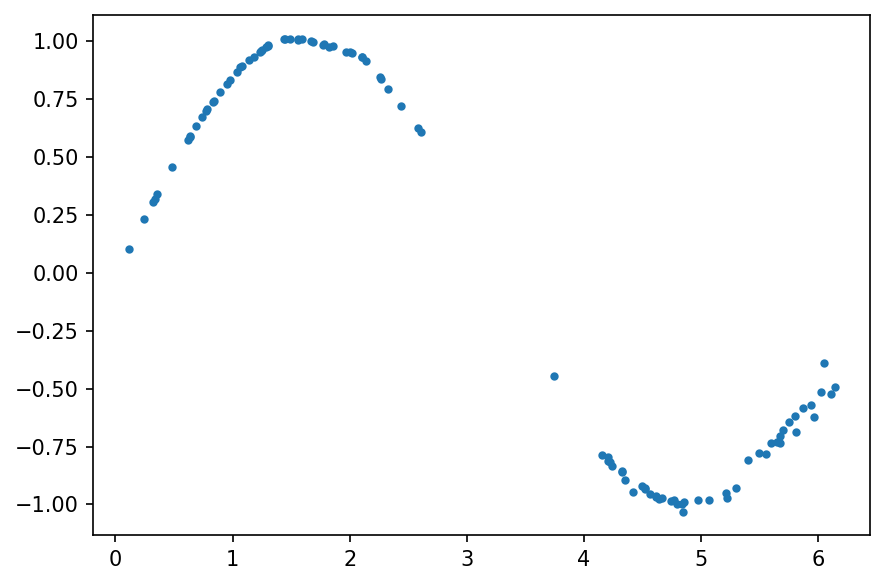

In [148]:
generated_samples = generated_samples.detach()
plt.figure(dpi=150)
plt.plot(generated_samples[:,0], generated_samples[:,1], '.')
plt.tight_layout()

# Getting the Data
Loading in some example beacon data to play with

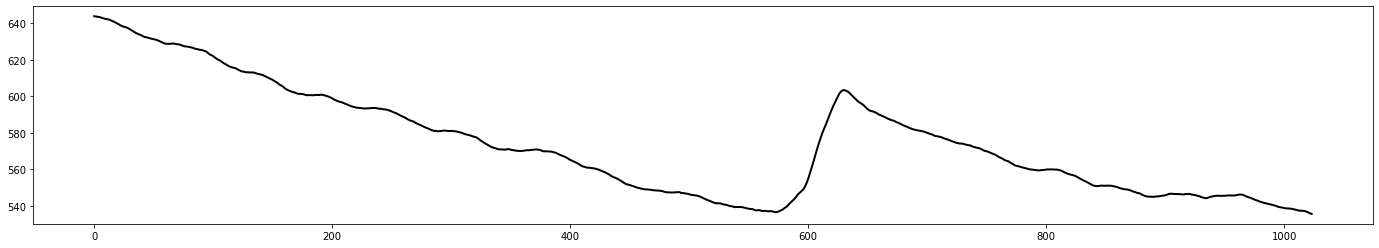

In [71]:
data = pd.read_csv("../data/interim/imputation/beacon-example-rnse61g4-ux_s20.csv",index_col=0,parse_dates=["timestamp"],infer_datetime_format=True)
_, ax = plt.subplots(figsize=(24,4))
data = data[datetime(2020,8,4):]
data = data.reset_index().iloc[:1024] 
ax.plot(data.index,data["co2"],lw=2,color="black")

plt.show()
plt.close()

Now we have a representative dataset to use

## Setting up Training Set
Torch requires a few formatting things

In [72]:
train_data_length = len(data)
train_data = torch.zeros((train_data_length,2))
train_data[:,0] = torch.tensor(np.arange(train_data_length))
train_data[:,1] = torch.tensor(data["co2"].values)
train_labels = torch.zeros(train_data_length) # dummy value

train_set = [
    (train_data[i], train_labels[i]) for i in range(train_data_length)
]

## Data Loader

In [116]:
batch_size = 128
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True
)

# Discriminator

In [117]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        output = self.model(x)
        return output

In [118]:
discriminator = Discriminator()

# Generator

In [119]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 2),
        )

    def forward(self, x):
        output = self.model(x)
        return output

In [120]:
generator = Generator()

# Training the Model

## Training Parameters

In [126]:
lr = 0.001
num_epochs = 300
loss_function = nn.BCELoss()

## Weight Updates

In [127]:
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

## Training

In [132]:
for epoch in range(num_epochs):
    for n, (real_samples, _) in enumerate(train_loader):
        # Data for training the discriminator
        real_samples_labels = torch.ones((batch_size, 1)) # labels of 1 to indicate ture/real samples
        latent_space_samples = torch.randn((batch_size, 2)) # random data
        generated_samples = generator(latent_space_samples)
        generated_samples_labels = torch.zeros((batch_size, 1)) # labels of 0 to indicate false/synthetic data
        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat(
            (real_samples_labels, generated_samples_labels)
        )

        # Training the discriminator
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        loss_discriminator = loss_function(
            output_discriminator, all_samples_labels)
        loss_discriminator.backward()
        optimizer_discriminator.step()

        # Data for training the generator
        latent_space_samples = torch.randn((batch_size, 2))

        # Training the generator
        generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_function(
            output_discriminator_generated, real_samples_labels
        )
        loss_generator.backward()
        optimizer_generator.step()

        # Show loss
        if epoch % 10 == 0:
            print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
            print(f"Epoch: {epoch} Loss G.: {loss_generator}")

0
Epoch: 0 Loss D.: 0.688028872013092
Epoch: 0 Loss G.: 0.7722556591033936
1
Epoch: 0 Loss D.: 0.6655636429786682
Epoch: 0 Loss G.: 0.7780150771141052
2
Epoch: 0 Loss D.: 0.6878910064697266
Epoch: 0 Loss G.: 0.7559552788734436
3
Epoch: 0 Loss D.: 0.688724160194397
Epoch: 0 Loss G.: 0.76587975025177
4
Epoch: 0 Loss D.: 0.6842447519302368
Epoch: 0 Loss G.: 0.7471709847450256
5
Epoch: 0 Loss D.: 0.6718913912773132
Epoch: 0 Loss G.: 0.7471503019332886
6
Epoch: 0 Loss D.: 0.6747111678123474
Epoch: 0 Loss G.: 0.7329069375991821
7
Epoch: 0 Loss D.: 0.668914258480072
Epoch: 0 Loss G.: 0.7505155801773071
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
Epoch: 10 Loss D.: 0.6760085821151733
Epoch: 10 Loss G.: 0.7445504665374756
1
Epoch: 10 Loss D.: 0.6856037974357605
Epoch: 10 Loss G.: 0.7294186353683472
2
Epoch: 10 Loss D.: 0.6862668991088867
Epoch: 10 Loss G.: 0.7532273530960083
3
Epoch: 10 Loss D.

3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
Epoch: 110 Loss D.: 0.6812872886657715
Epoch: 110 Loss G.: 0.7159067988395691
1
Epoch: 110 Loss D.: 0.7022616267204285
Epoch: 110 Loss G.: 0.6993192434310913
2
Epoch: 110 Loss D.: 0.6841268539428711
Epoch: 110 Loss G.: 0.7140346169471741
3
Epoch: 110 Loss D.: 0.6861405968666077
Epoch: 110 Loss G.: 0.7280532717704773
4
Epoch: 110 Loss D.: 0.6884050965309143
Epoch: 110 Loss G.: 0.7157163023948669
5
Epoch: 110 Loss D.: 0.6937296390533447
Epoch: 110 Loss G.: 0.735454261302948
6
Epoch: 110 Loss D.: 0.6965433955192566
Epoch: 110 Loss G.: 0.7212814092636108
7
Epoch: 110 Loss D.: 0.6908635497093201
Epoch: 110 Loss G.: 0.7386229634284973
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
Epoch: 120 Loss D.: 0.6927278637886047
Epoch: 120 Loss G.: 0.7187722325325012

4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
Epoch: 220 Loss D.: 0.6954326629638672
Epoch: 220 Loss G.: 0.674389660358429
1
Epoch: 220 Loss D.: 0.696702778339386
Epoch: 220 Loss G.: 0.685028076171875
2
Epoch: 220 Loss D.: 0.6950328350067139
Epoch: 220 Loss G.: 0.6881987452507019
3
Epoch: 220 Loss D.: 0.6919893622398376
Epoch: 220 Loss G.: 0.6884920001029968
4
Epoch: 220 Loss D.: 0.6883468627929688
Epoch: 220 Loss G.: 0.692268431186676
5
Epoch: 220 Loss D.: 0.6907454133033752
Epoch: 220 Loss G.: 0.6904160976409912
6
Epoch: 220 Loss D.: 0.6866726279258728
Epoch: 220 Loss G.: 0.6864197254180908
7
Epoch: 220 Loss D.: 0.6951329112052917
Epoch: 220 Loss G.: 0.6969809532165527
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
Epoch: 230 Loss D.: 0.6919267177581787
Epoch: 230 Loss G.: 0.6974509954452515
1
Epoch: 230 Loss D.: 0.6915691494941711
Epoch: 230 

In [129]:
latent_space_samples = torch.randn(100, 2)
generated_samples = generator(latent_space_samples)

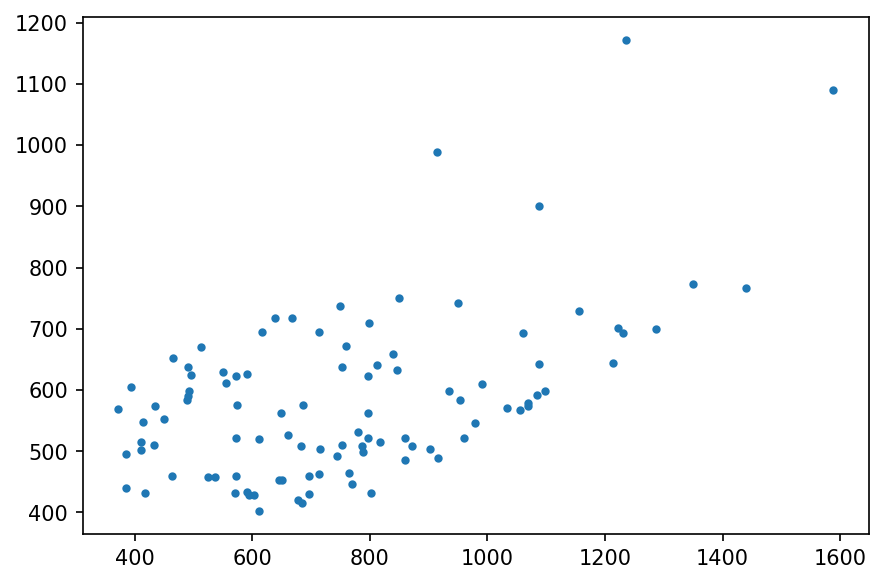

In [130]:
generated_samples = generated_samples.detach()
plt.figure(dpi=150)
plt.plot(generated_samples[:,0], generated_samples[:,1], '.')
plt.tight_layout()